<img src="https://www.uss.cl/wp-content/themes/uss/img/logo.svg" width="200" height="200" style="float:left; padding:10px"/>

# Proyecto de Text Mining: Plebiscito 2022

- Por Nicole Lastra Quiroz
----------

## Desarrollo del proyecto

Se inicia el proyecto con la instalación de librerías ausentes en el entorno de Google Colab.

In [4]:
!pip install pysentimiento

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 22.1 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=59d6161c8db22af4165daeadd1f21f1012c3527fc88bd1837b5f067a3b87ffec
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df820

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Se cargan las librerías, sin olvidar el ignorar los warnings para efectos de limpieza del código.

In [6]:
# Carga de librerías
# ---------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import sklearn.neighbors
import sklearn.metrics as metrics
import requests
import json
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from textblob import TextBlob
from pysentimiento import create_analyzer
from pysentimiento.preprocessing import preprocess_tweet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB 
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Carga de datos

Se procede con la carga de datos, los cuales han sido entregados en dos archivos `.xlsx`. 

Cabe señalar, que éstos datos corresponden a una recolección de tweets del día 3 de septiembre, y del día 6 de septiembre, con la finalidad de estudiar tendencias y un análisis de sentimientos, pre y post plebiscito respectivamente.

In [7]:
# Carga de datos:
# ------------------------------------------------------------------------------
pre  = pd.read_excel('Sept3.xlsx', sheet_name = 'Tweets')
post = pd.read_excel('Sept6.xlsx', sheet_name = 'tweets')


Se visualizan ejemplos de ambos set de datos:

In [8]:
# Para ver 3 filas de ejemplo del contenido de pre
# ------------------------------------------------------------------------------
pre.sample(3) 

,tweet_id,screen_name,utc_date,source,favorites,retweets,replies,quotes,lang,tweet_type,...,country_code,place,latitude,longitude,urls,media_type,media1,media2,media3,media4
6,1554980234969206786,rcornejocaceres,2022-08-03T23:59:12.000Z,Twitter for Android,1,1,0,0,es,tweet,...,NaN,NaN,NaN,NaN,https://twitter.com/javiarce/status/1554861948...,NaN,NaN,NaN,NaN,NaN
4689,1554678445216374787,malaespinacheck,2022-08-03T04:00:00.000Z,Twitter Web App,1,0,0,0,es,tweet,...,NaN,NaN,NaN,NaN,https://api.whatsapp.com/message/6MOYYP62MJA3A...,photo,https://pbs.twimg.com/media/FZMfbvDWYAAZEUF.png,NaN,NaN,NaN
1608,1554905267795595265,de_aqui_y_alla,2022-08-03T19:01:19.000Z,Twitter Web App,4,0,0,0,es,reply,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Para ver 6 filas de ejemplo del contenido de post
# ------------------------------------------------------------------------------
post.sample(3)

,Tweet ID,Tweet URL,Tweet Posted Time,Tweet Type,Tweet Text,Tweet Text Length,Client,Client URL,Total Retweets,Total Likes,...,Original Author Total Followers,Original Author Total Following,Original Author Total Public Lists,Original Author Total Likes,Original Author Total Tweets,Original Author Verified Account,Original Author Protected Tweets,Original Author Created At (UTC),Original Author Possible Email,Original Author Possible Phone
21502,1566976116455358471,https://twitter.com/rinostrozal/status/1566976...,2022-09-06 02:26:33,Retweet,"Los verdaderos héroes, Carabineros 🇨🇱♥️ Fueron...",270,Twitter for Android,http://twitter.com/download/android,3430,8505,...,142,406,4,675,635,False,False,2020-03-26 00:16:39,NaN,NaN
9713,1567160295239389188,https://twitter.com/la_gata_peluda/status/1567...,2022-09-06 14:38:25,Retweet,#LeyDeMediosYa la moneda desesperada buscando ...,124,Twitter for Android,http://twitter.com/download/android,39,31,...,1102,2555,0,6269,1578,False,False,2020-10-15 22:55:46,NaN,NaN
3302,1567251494411595776,https://twitter.com/juanesvielma/status/156725...,2022-09-06 20:40:49,Retweet,Pregunta seria... En las 2 millones de casas m...,160,Twitter for Android,http://twitter.com/download/android,392,912,...,6684,4848,3,45793,10630,False,False,2012-10-21 19:58:39,NaN,NaN


### Exploración de datos

Se realizan revisiones básicas, identificando nombre de  columnas, cantidad de datos, así como información respectiva a valores nulos y tipos de datos, en ambos set de datos.

#### Datos previos a plebiscito

In [10]:
# Columnas en pre:
# ------------------------------------------------------------------------------
print('Nombre columnas:', pre.columns)

# Número de columnas y filas en pre:
# ------------------------------------------------------------------------------
print('Cantidad de Filas y columnas:', pre.shape)

Nombre columnas: Index(['tweet_id', 'screen_name', 'utc_date', 'source', 'favorites',
       'retweets', 'replies', 'quotes', 'lang', 'tweet_type', 'text', 'quote',
       'country_code', 'place', 'latitude', 'longitude', 'urls', 'media_type',
       'media1', 'media2', 'media3', 'media4'],
      dtype='object')
Cantidad de Filas y columnas: (6500, 22)


In [11]:
# Información de las variables en el pre set:
# ------------------------------------------------------------------------------
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_id      6500 non-null   int64  
 1   screen_name   6500 non-null   object 
 2   utc_date      6500 non-null   object 
 3   source        6500 non-null   object 
 4   favorites     6500 non-null   int64  
 5   retweets      6500 non-null   int64  
 6   replies       6500 non-null   int64  
 7   quotes        6500 non-null   int64  
 8   lang          6500 non-null   object 
 9   tweet_type    6500 non-null   object 
 10  text          6500 non-null   object 
 11  quote         1538 non-null   object 
 12  country_code  199 non-null    object 
 13  place         199 non-null    object 
 14  latitude      199 non-null    float64
 15  longitude     199 non-null    float64
 16  urls          2002 non-null   object 
 17  media_type    1736 non-null   object 
 18  media1        1736 non-null 

#### Datos posterior a plebiscito

In [12]:
# Columnas en pre:
# ------------------------------------------------------------------------------
print('Nombre columnas:', post.columns)

# Número de columnas y filas en pre:
# ------------------------------------------------------------------------------
print('Cantidad de Filas y columnas:', post.shape)

Nombre columnas: Index(['Tweet ID', 'Tweet URL', 'Tweet Posted Time', 'Tweet Type',
       'Tweet Text', 'Tweet Text Length', 'Client', 'Client URL',
       'Total Retweets', 'Total Likes', 'Language', 'Sensitive Content',
       'Replying To Username', 'Mentions', 'Hashtags', 'Emojis', 'Symbols',
       'Total Mentions', 'Total Hashtags', 'Total URLs', 'Total Media',
       'Total Emojis', 'Total Symbols', 'Total Polls', 'URL', 'Media type',
       'Media URL', 'Tweet Truncated', 'Original Author Twitter ID',
       'Original Author Full name', 'Original Author Screen name',
       'Original Author Location', 'Original Author Description (Bio)',
       'Original Author Website', 'Original Author Total Followers',
       'Original Author Total Following', 'Original Author Total Public Lists',
       'Original Author Total Likes', 'Original Author Total Tweets',
       'Original Author Verified Account', 'Original Author Protected Tweets',
       'Original Author Created At (UTC)', 'Ori

In [13]:
# Información de las variables en el pre set:
# ------------------------------------------------------------------------------
post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Tweet ID                            25000 non-null  int64  
 1   Tweet URL                           25000 non-null  object 
 2   Tweet Posted Time                   25000 non-null  object 
 3   Tweet Type                          25000 non-null  object 
 4   Tweet Text                          25000 non-null  object 
 5   Tweet Text Length                   25000 non-null  int64  
 6   Client                              25000 non-null  object 
 7   Client URL                          25000 non-null  object 
 8   Total Retweets                      25000 non-null  int64  
 9   Total Likes                         25000 non-null  int64  
 10  Language                            25000 non-null  object 
 11  Sensitive Content                   16696

#### Generalidades observadas


* El set de datos ´pre´ posee menos columnas que ´post´ 
* Ambos set de datos comparten columnas (sin poseer necesariamente el mismo nombre de dicha columna) referentes a identificación de los tweets, nombre de usuario, retweets, respuestas, citas, idioma, ulr y los tweets en sí.
* Hay datos nulos en cantidades considerables en ambos set de datos, pero no en las columnas referidas a datos escenciales para realizar este estudio.

### Limpieza de datos 

#### Limpieza general de columnas

En ambos set de datos se eliminarán columnas innecesarias para este estudio, dejando únicamente columnas referidas a autoría de los tweets, número de likes, de retweets, y el texto del tweet como tal. También, se adicionará la columna `Fecha`, de modo que se pueda generar un sólo dataframe a trabajar, pero se mantengan las individualidades respecto al período en que se captaron.


In [14]:
# Eliminación de duplicados y reset + Visualización de 5 tweets
# ---------------------------------------------------------------------
predf = pre.drop(columns =['tweet_id',
                          'utc_date', 
                          'source',
                          'quotes', 
                          'lang', 
                          'replies',
                          'tweet_type', 
                          'quote',
                          'country_code', 
                          'place', 
                          'latitude', 
                          'longitude', 
                          'urls', 
                          'media_type',
                          'media1', 
                          'media2', 
                          'media3', 
                          'media4'])

predf.columns = ['Autor','Likes', 'Retweets', 'Tweet',]
predf['Tweet'] = predf['Tweet'].astype('string')
predf['Autor'] = predf['Autor'].astype('string')
predf['Fecha'] = '03/09/2022'
predf['Fecha'] = predf['Fecha'].astype('string')

predf = predf.reindex(columns=['Fecha','Tweet','Autor','Likes', 'Retweets'])

predf.head()

,Fecha,Tweet,Autor,Likes,Retweets
0,03/09/2022,@Profecampusano Profe espero su bloqueo! #Apru...,Crigz5,1,0
1,03/09/2022,Ruta 78 #Rechazo https://t.co/trceeSRDLQ,Lucho_AlbertoRG,1,0
2,03/09/2022,#APRUEBO...ESTE DE LA DROGA..MIENTEN Y CADEM ...,Aliro2151,0,0
3,03/09/2022,¡La nueva Constitución llegó a Chanco y camina...,fersalinas333,7,2
4,03/09/2022,GENIAL!!! Tal cual!!! Así estamos o estaremos ...,YankoNereo,1,2


In [15]:
# Revison de forma de pretdf
# ---------------------------------------------------------------------
predf.shape

(6500, 5)

In [16]:
# Eliminación de duplicados y reset + Visualización de 5 tweets
# ---------------------------------------------------------------------
postdf = post.drop(columns =['Tweet ID',
                             'Tweet URL', 
                             'Tweet Posted Time', 
                             'Tweet Type',
                             'Tweet Text Length', 
                             'Client', 
                             'Client URL',
                             'Sensitive Content', 
                             'Language',
                             'Mentions',
                             'Emojis', 
                             'Symbols', 
                             'Hashtags',
                             'Total Mentions',
                             'Replying To Username', 
                             'Total Hashtags', 
                             'Total URLs', 
                             'Total Media',
                             'Total Emojis', 
                             'Total Symbols', 
                             'Total Polls', 
                             'URL', 
                             'Media type', 
                             'Media URL', 
                             'Tweet Truncated', 
                             'Original Author Twitter ID',  
                             'Original Author Full name',
                             'Original Author Location', 
                             'Original Author Description (Bio)',
                             'Original Author Website', 
                             'Original Author Total Followers',
                             'Original Author Total Following', 
                             'Original Author Total Public Lists',
                             'Original Author Total Likes', 
                             'Original Author Total Tweets',
                             'Original Author Verified Account', 
                             'Original Author Protected Tweets',
                             'Original Author Created At (UTC)', 
                             'Original Author Possible Email',
                             'Original Author Possible Phone'])


postdf.columns = ['Tweet','Retweets', 'Likes', 'Autor']
postdf['Tweet'] = postdf['Tweet'].astype('string')
postdf['Autor'] = postdf['Autor'].astype('string')
postdf['Fecha'] = '06/09/2022'
postdf['Fecha'] = postdf['Fecha'].astype('string')


postdf = postdf.reindex(columns=['Fecha','Tweet','Autor','Likes', 'Retweets'])

postdf.head()


,Fecha,Tweet,Autor,Likes,Retweets
0,06/09/2022,Hago un Llamado a todos los Chilenos q Aman Ch...,Danny_I7I,6,6
1,06/09/2022,De a poco comienzan a salir los engañados del ...,LadyGarfia,3110,729
2,06/09/2022,Nadie se dio cuenta que el orden de las bander...,CiudadanoDs2020,744,408
3,06/09/2022,"Al hijo de Keitel la izquierda extrema, los ar...",AngelDLaCruz_,44,58
4,06/09/2022,Declaración de Gobernadores y Gobernadoras de ...,Orrego,5002,1364


In [17]:
# Revison de forma de postdf
# ---------------------------------------------------------------------
postdf.shape

(25000, 5)

In [18]:
# Concatenación de ambos set de datos en df + sampleo de revisión
# ---------------------------------------------------------------------
df = pd.concat([predf, postdf])
df.sample(3)

,Fecha,Tweet,Autor,Likes,Retweets
12120,06/09/2022,"Los verdaderos héroes, Carabineros 🇨🇱♥️ Fueron...",EmilionaireF,8505,3430
4504,06/09/2022,"Jajajaj.... Es bueno, por que es cierto 🤣🤣 #Ch...",AlexDurYav,1999,474
21733,06/09/2022,El presidente de Colombia apoya la dictadura d...,Carsuarez19,641,347


In [19]:
# Revison de información general de df
# ---------------------------------------------------------------------
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31500 entries, 0 to 24999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     31500 non-null  string
 1   Tweet     31500 non-null  string
 2   Autor     31500 non-null  string
 3   Likes     31500 non-null  int64 
 4   Retweets  31500 non-null  int64 
dtypes: int64(2), string(3)
memory usage: 1.4 MB


#### Tweets duplicados

Se procederá a eliminar los tweets duplicados ya que:

1. Éstos no aportan al foco del estudio
2. Se ahorran recursos de procesamiento 

In [20]:
# Eliminación de duplicados y reset
# ---------------------------------------------------------------------
df = df.drop_duplicates(keep = "first")
df = df.reset_index(drop = True)

df.shape

(11173, 5)

De los 31500 tweets iniciales, sólo han quedado 11173, pero al haber concatenado los dataframes anteriores, no se tiene claridad si los tweets repetidos provienen del 3 de septiembre o del 6 de septiembre.

Para identificar específicamente de donde salen éstos tweets, se realizará un estudio de los set de datos en su forma previa.

In [21]:
# Revison de forma del dataset postdf
# ---------------------------------------------------------------------
predf = predf.drop_duplicates(keep = "first")
predf = predf.reset_index(drop = True)
predf.shape

(6457, 5)

In [22]:
# Eliminación de duplicados y reset
# ---------------------------------------------------------------------
postdf = postdf.drop_duplicates(keep = "first")
postdf  = postdf.reset_index(drop = True)
postdf.shape

(4716, 5)

Al observar los resultados, se concluye que: 
- 540 tweets pertenecían al set de datos previo al plebiscito, y más de 20.000 al set de datos posterior a él
- Existe un número dispar entre tweets del 3 septiembre y tweets del 6 de septiembre, lo que se debe tener en cuenta a la hora de realizar análisis en etapas futuras sobretodo respecto a frecuencias.


#### Autoría de tweets

Se realiza un estudio de autoría de tweets (set de datos por separado), para identificar a los dos autores más influyentes de las respectivas fechas.

In [23]:
# Conteo de etiquetas según categoría en training set
# ---------------------------------------------------------------------
predf.Autor.value_counts()

YoApoyoAChile      138
berner_teresa      108
cdkr_ck             64
Marifesa27          57
stitch_luis         51
                  ... 
henriquezlibre       1
EduardoOrchard       1
Chilequidad          1
AteneitaMinerva      1
loquillo_666         1
Name: Autor, Length: 3104, dtype: Int64

Las dos cuentas con mayor producción de tweets previos corresponden: 


1.   _YoApoyoAChile_, cuenta colectiva que declaraba públicamente en su información de usuario el rechazar.
2.   _berner_teresa_, quien declaraba públicamete aprobar en su información de usuario aprobar.


In [24]:
# Conteo de etiquetas según categoría en training set
# ---------------------------------------------------------------------
postdf.Autor.value_counts()

Dpm_Chile2020      147
Francis28192809     84
ColoCol56346379     33
luedomora           24
Isitacake           24
                  ... 
Mileinnials          1
kiyomi_bae           1
CristianLuengo       1
alexjimeneztv        1
a_ortuya             1
Name: Autor, Length: 2930, dtype: Int64

Las dos cuentas con mayor producción de tweets posteriores corresponden: 

1. _Dpm_Chile2020_, cuenta que se declara sin ideología política, pero cuyo contenido es en base a comentarios contra movimiento de derecha.
2. _Francis28192809_, cuenta de jubilado republicano, según indica su información, con contenido base a comentarios contra acciones del gobierno actual.

**Hallazgos generales**

* Se observa que existe un equilibrio entre los lados extremos u opuestos entre los primeros lugares, con una ligera inclinación previa a favor del rechazo y posterior en contra de movimientos de dercha.
* 3 de las 4 cuentas con más tweets corresponden usuarios a del tipo "persona natural" y no a cuentas de noticias o difusión.
* En el caso de _YoApoyoAChile_ , la cuenta hacia autoreferecias en plural, y su temática era del tipo propaganda en contra de movimientos políticos que no fueran de derecha. A la afecha tiene como nombre _"Pueblo Con Sentido (YACH)"_, y sigue dedicandose a lo mismo, en un contexto actualizado.

_Observación: La información específica sobre los autores ha sido recabada directamente desde sus cuentas de twitter._

### Visualizaciones - Nube de palabras

#### Lematizado y corpus

Se define un objeto para llamar a `WordNetLemmatizer()`.

In [25]:
# Creación de objeto para lemmatization
# ---------------------------------------------------------------------
lm = WordNetLemmatizer()

Se crea un objeto contenedor de las stopwords en español.

In [26]:
# Obtención de listado de stopwords del español
# ---------------------------------------------------------------------
stop_words = list(stopwords.words('spanish'))

# Se modifican las stopwords
# ---------------------------------------------------------------------
stop_words.extend(list(stopwords.words('english')))
stop_words.append('compartir')
stop_words.append('comentar')
stop_words.append('ma')
stop_words.append('así')
stop_words.append('hagamos')


print(stop_words)


['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

Se procede con el preprocesado de la información, en donde se definirá el corpus y las restricciones de este, como la eliminación de las páginas web, el convertido a minúsculas de todas las palabras, la separación de las palabras como items, la eliminación de las stopwords, entre otros.

In [27]:
# Preprocesado de la información
# ---------------------------------------------------------------------

def text_transformation(df_col):
    corpus = []
    
    for item in df_col:
        # Eliminación de páginas web (palabras que empiezan por "http")
        # -------------------------------------------------------------
        new_item = re.sub('http\S+', ' ', str(item))
        
        # Eliminación de signos de puntuación
        # -------------------------------------------------------------
        regex = '[\\!\\"\\#\\$\\%\\&\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\&\\´]'
        new_item = re.sub(regex , ' ', new_item)
        
        #eliminar cualquier caracter que no pertenezca al alfabeto
        # -------------------------------------------------------------
        #new_item = re.sub('[^a-zA-Z]',' ', new_item)
    
        
        #convertir a minuscula
        # -------------------------------------------------------------
        new_item = new_item.lower() 
        new_item = re.split('\W+', new_item) 
        
        # Se mantienen tokens con una longitud de 2 o mas letras +
        # Busqueda/eliminación de stopwords + lematizatizado de palabras
        # -------------------------------------------------------------
        new_item = [token for token in new_item if len(token) > 2]
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stop_words)]
        
        # Verificar si la palabra ya ha sido procesada
        # -------------------------------------------------------------
        for word in new_item:
          if word not in corpus:
            # Añadir la palabra al conjunto
            corpus.append(word)
            
       # union de corpus final
       # -------------------------------------------------------------
        corpus.append(' '.join(str(x) for x in new_item))
        
   # Devolución de un corpus de los datos procesados
   # ------------------------------------------------------------------
    return corpus

Se aplica la función creada en el preprocessing de los tweets y se guardan en los corpus respectivos.

##### Corpus de datros previos al plebiscito

In [28]:
# Aplicar función de preprocessing al texto + guardado en corpus
# ---------------------------------------------------------------------
corpuspre = text_transformation(predf['Tweet'])

In [29]:
for i in range(len(corpuspre)):
    corpuspre[i] = corpuspre[i].replace("grau grau", "grau")
    corpuspre[i] = corpuspre[i].replace("apruebocrece", "apruebo")



##### Corpus de datros posteriores al plebiscito

In [30]:
# Aplicar función de preprocessing al texto + guardado en corpus
# ---------------------------------------------------------------------
corpuspost = text_transformation(postdf['Tweet'])

In [31]:
for i in range(len(corpuspost)):
    corpuspost[i] = corpuspost[i].replace("grau grau", "grau")
    corpuspost[i] = corpuspost[i].replace("apruebocrece", "apruebo crece")

#### Nube de plabras

Se crea un `WordCloud` en base a cada corpus generado.

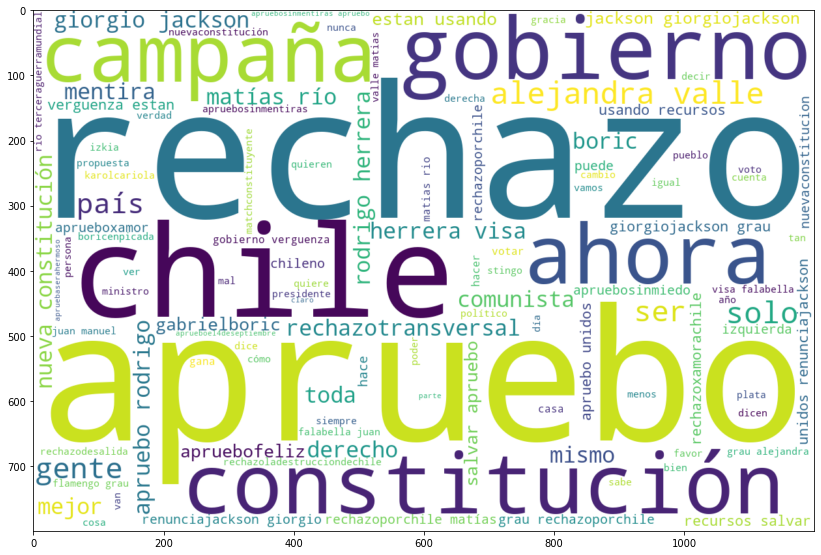

In [32]:
#Creación de wordcloud para ver las palabras más frecuentes
# ---------------------------------------------------------------------
plt.figure(figsize = (14, 10))

word_cloud = ""

for row in corpuspre:
    for word in row:
        word_cloud += " ".join(word)
        
wordcloud = WordCloud(width                 = 1200, 
                      height                = 800,
                      background_color      ='white',
                      max_words             = 3000,
                      stopwords             = stop_words,
                      regexp                = r"\w+",
                      collocation_threshold = 200,
                      min_font_size    = 11).generate(word_cloud)

plt.imshow(wordcloud, interpolation = 'bilinear')

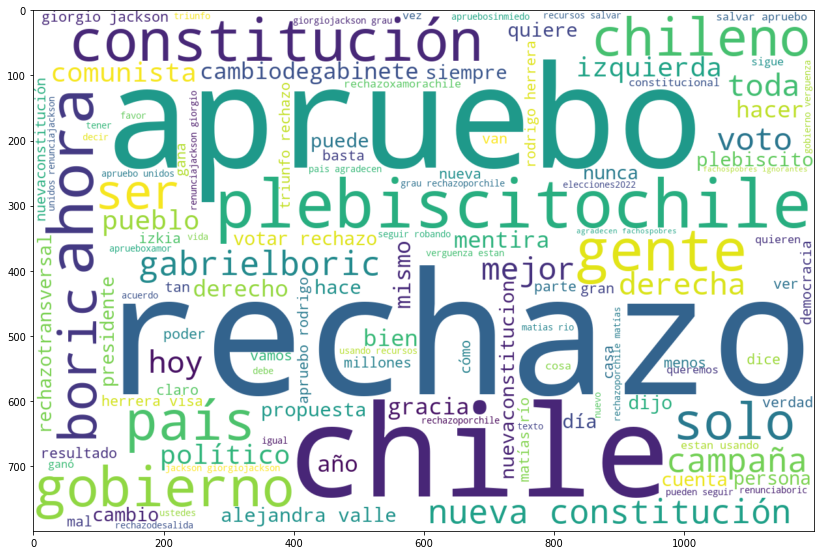

In [33]:
#Creación de wordcloud para ver las palabras más frecuentes
# ---------------------------------------------------------------------
plt.figure(figsize = (14, 10))

word_cloud2 = ""

for row in corpuspost:
    for word in row:
        word_cloud += " ".join(word)
        
wordcloud = WordCloud(width                 = 1200, 
                      height                = 800,
                      background_color      ='white',
                      max_words             = 3000,
                      stopwords             = stop_words,
                      regexp                = r"\w+",
                      collocation_threshold = 200,
                      min_font_size    = 11).generate(word_cloud)

plt.imshow(wordcloud, interpolation = 'bilinear')

En general, en la comparativa de ambas nubes de palabras, se puede observar que:

* Hay palabras emblemáticas en ambas fechas, como "apruebo", "rechazo" y "chile", las cuales no se ven afectadas drásticamente como otros conceptos.
* Posterior al plebiscito se produce una baja en la presencia de "gobierno", al tiempo que aumenta la de "boric" y "gabrielboric" (hashtag). De igual forma disminuyen las palabras "constitución" y "campaña", mientras que aumentan conceptos como "chileno", "ser", "solo" y "comunista", principalmente.
* La influencia de personajes asociados a movimientos o eventos de las diferentes campañas, es fuerte y variada en la nube de palabras del período previo, pero disminuye considerablemente en la etapa postterior (ejemplo, el caso de "Alejandra Valle").






### Pysentimientos


Según indican Pérez et al (2021), **pysentimiento** es un una librería que utiliza modelos pre-entrenados de transformers para distintas tareas de SocialNLP, tanto en español (en base a BETO y RoBERTuito), como en inglés (en base a BERTweet).

Además de las tareas propias del análisis de sentimientos (análisis de polaridad, de emociones y del discurso de odio), **pysentimiento** permite realizar el preprocesado del texto, consiguiendo de forma rápida y efectiva un tokenizado acorde a las necesidades de los modelos bajo los que se realizará el análisis.



_Observación 2: Se decide trabajar únicamente con **pysentimientos**, ya que sus resultados están respaldados por una notable mejora en la precisión, respecto de otros modelos en general, y más aún cuando se trata del idioma "español", gracias al uso de BETO y RoBERTuito, como se aprecia en Pérez et al (2021) en "pysentimiento: A python toolkit for sentiment analysis and socialnlp tasks" y en "Robertuito: a pre-trained language model for social media text in spanish". Eso sí, se realizarán los tres tipos análisis disponible a los datos en la mencionada librería, para generar el equivalente a realizar un sólo tipo de análisis con diferentes modelos een base a Machine Learning._

#### Preprocesado

Se realizará un preprocesado de los tweets por medio de **pysentimiento**, específicamente el módulo `preprocess_tweet`.




In [34]:
# Auxiliares
# ---------------------------------------------------------------------
tweet = df['Tweet']
auxt  = []

# Preprocesado de tweets con Pysentimiento 
# ---------------------------------------------------------------------
for row in tweet:
  try:
    row = preprocess_tweet(row)
    auxt.append(row)
  except StopIteration:
    break

In [35]:
# Preprocesado de tweets
# ---------------------------------------------------------------------
df['Tweet_T'] = auxt
df.sample(10)

,Fecha,Tweet,Autor,Likes,Retweets,Tweet_T
7642,06/09/2022,Una pequeña asesoría al gratin!! #merluzo!! #r...,ElCamioneroCL,190,121,Una pequeña asesoría al gratin!! merluzo!! rec...
10298,06/09/2022,Creo que a Boric en Chile con el #Apruebo le p...,jorge1988moral,0,0,Creo que a Boric en Chile con el apruebo le pa...
2138,03/09/2022,Se imaginan seguir así por 3 1/2 años más...? ...,MonraMatta,0,0,Se imaginan seguir así por 3 1/2 años más...?\...
7036,06/09/2022,Leyendo la Nueva Constitución: 1. Se mantiene ...,nomastonteras,6,3,Leyendo la Nueva Constitución: 1. Se mantiene ...
6700,06/09/2022,Felicidades al pueblo chileno. Dijeron NO al c...,s_magliano,252,69,Felicidades al pueblo chileno. Dijeron NO al c...
4767,03/09/2022,LOS PERIODISTAS DEL MEGA SONRIEN AL CONTAR MAL...,berner_teresa,0,0,LOS PERIODISTAS DEL MEGA SONRIEN AL CONTAR MAL...
9828,06/09/2022,@ClaudiaPizarro CDR tratar de desmarcarse ahor...,eduardopinedaa,4,2,@usuario CDR tratar de desmarcarse ahora desta...
1430,03/09/2022,@MaxiPatriota https://t.co/dQ5qcJ0HAZ RT comen...,YoApoyoAChile,0,0,"@usuario url RT comentar y compartir,gobierno ..."
2910,03/09/2022,@ximerincon Bien ..esta mostrando la cara que ...,OrtubiaPeralta,0,0,@usuario Bien ..esta mostrando la cara que sie...
7935,06/09/2022,Celebrando en #Iquique el histórico triunfo. V...,natanolivos,33,6,Celebrando en iquique el histórico triunfo. Vi...


#### Polaridad de tweets

Para realizar una revisión a la polaridad de los tweets, se definirá un objeto con dicha tarea en lenguaje en español, usando `create_analyzer` de **pysentimiento**. Como resultado, se obtendrá un texto que indicará la etiqueta final asignada como output, así como la probabilidad de cada una de las etiquetas posibles: 
- `NEU`, que indica neutralidad
- `NEG`, que indica negatividad
- `POS`, que indica positividad

Se debe precisar que, para efectos de este estudio, sólo se trabajará con la etiqueta entregada como output por el modelo. 

In [36]:
# Creación de analizador por polarización en español 
# ---------------------------------------------------------------------
analizador = create_analyzer(task = "sentiment", 
                           lang = "es"
                           )

In [37]:
# Análisis de sentimientos (polaridad) de tweets preprocesados
# ---------------------------------------------------------------------
df['Polaridad_PyS'] = analizador.predict(df['Tweet_T'])

  0%|          | 0/350 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 11173
  Batch size = 32
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [38]:
# Guardado de tweets tookenizados como string 
# ---------------------------------------------------------------------
df['Polaridad_PyS'] = df['Polaridad_PyS'].astype('string')
df.sample(3)

,Fecha,Tweet,Autor,Likes,Retweets,Tweet_T,Polaridad_PyS
7136,06/09/2022,#PlebiscitoChile asi fue https://t.co/6rmF2zBSuF,jcff143,0,0,plebiscito chile asi fue url,"AnalyzerOutput(output=NEU, probas={NEU: 0.983,..."
756,03/09/2022,#SumoMiCasaXElApruebo #AprueboCrece #apruebo h...,jossitocastror,1,0,sumo mi casa xel apruebo apruebo crece apruebo...,"AnalyzerOutput(output=NEU, probas={NEU: 0.849,..."
8047,06/09/2022,Como votante del #Apruebo creo que ya no queda...,cs_kratos,1,0,Como votante del apruebo creo que ya no queda ...,"AnalyzerOutput(output=NEU, probas={NEU: 0.785,..."


In [39]:
# Separación de analisis obtenido y asignación de columnas
# ---------------------------------------------------------------------
aux = df['Polaridad_PyS'].str.split(',', expand = True)
aux.columns = ['cero', 'uno', 'dos', 'tres']
aux.sample(3)

,cero,uno,dos,tres
2152,AnalyzerOutput(output=NEG,probas={NEG: 0.924,NEU: 0.067,POS: 0.009})
2524,AnalyzerOutput(output=NEU,probas={NEU: 0.956,NEG: 0.030,POS: 0.014})
5570,AnalyzerOutput(output=NEG,probas={NEG: 0.979,NEU: 0.019,POS: 0.002})


In [40]:
# Auxiliares
# ---------------------------------------------------------------------
cero     = aux['cero']
aux0 = []

# Separación de etiqueta en columna cero 
# ---------------------------------------------------------------------
startLoc = 22
endLoc   = 25

for row in cero:
  try:
    row = row[startLoc: endLoc]
    aux0.append(row)
  except StopIteration:
    break

df['Polaridad_PyS'] = aux0
df.sample(3)

,Fecha,Tweet,Autor,Likes,Retweets,Tweet_T,Polaridad_PyS
3999,03/09/2022,@ChrisXOva @mcollao08 @pablojaeger No sé como ...,GabrielRepubli2,0,0,@usuario @usuario @usuario No sé como explicar...,NEU
847,03/09/2022,Yo quiero seguir viviendo en Chile como chilen...,jtg_chile,0,0,Yo quiero seguir viviendo en Chile como chilen...,NEU
251,03/09/2022,@NicoKyojin Y votando #apruebo,yoyarzuna,0,0,@usuario Y votando apruebo,NEU


Para visualizar los datos de modo que la comparativa entre los tweets previos al plebiscito del 4 de septiembre, así como y los posteriores a este evento, sea clara, se realizará un grafico de barra con las frecuencias de las etiquetas.

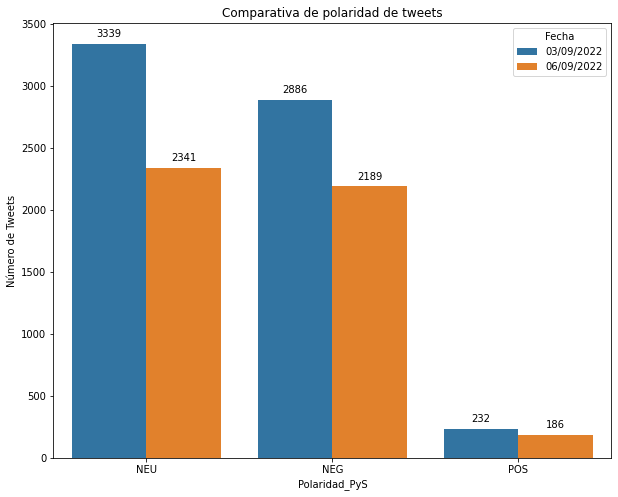

In [41]:
# Gráfico de barras - polaridad - Etiquetas por fecha
# ---------------------------------------------------------------------
fig , ax = plt.subplots(figsize = (10,8))

sns.countplot(x    = 'Polaridad_PyS', 
              data = df,
              hue  = 'Fecha'
              )

# Función para agregar n° de las barras
# ---------------------------------------------------------------------
def add_value_labels(ax, spacing = 5):
    """Agrega etiquetas al final de las barras en un gráfico que incluya barras.

    Argumentoss:
        ax (matplotlib.axes.Axes): El objeto matplotlib contiene los ejes del gráfico en los que se quiere anotar.
        spacing (int): Distancia entre etiquetas y barras.
    """

    # Etiqueta para cada barra
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space   = spacing
        va      = 'bottom'

        # Etiquetado de valores de eje Y en formato número entero
        label = "{:.0f}".format(round(y_value))


        # Anotación por fecha
        ax.annotate(
            label,                        
            (x_value, y_value),           
            xytext     = (0, space),      
            textcoords = 'offset points', 
            ha         = 'center',        
            va         = va               
            )                                 
                                        
add_value_labels(ax)         

plt.ylabel("Número de Tweets")
plt.title('Comparativa de polaridad de tweets')
plt.show()
plt.close('all')


Si bien no se pueden comparar las frecuencias exactas de cada fecha, ya que no existe un número equitativo de tweets en cada una, sí se puede realizar una comparativa que considere la tendencia aproximada de la distribución de columnas. Es así que al observar la gráfica, y según el modelo utilizado, se puede precisar que en ambos casos la mayoría de los tweets tienen un contenido neutro. Muy de cerca en números, siguen los tweets con la etiqueta asociada a negatividad, y son mas bien escasos, en proporción, aquellos de carácter positivo.

La alta tasa de neutralidad podría ser signo de un enfrentamiento del proceso de plebiscito constitucional con objetividad y respeto por parte de la mayoría de usuarios en Twitter, pero no se descarta que esos resultados tengan origen en el procesado/preprocesado del modelo, dadas las características propias del lenguaje "español chileno", más aún al expresarse por redes sociales.

Dada las tendencias, también se presume que las campañas realizadas por simpatizantes  tanto del Apruebo como del Rechazo en Twitter, se basaron más en aspectos negativos de la propuesta contraria, que en lo positivo de la propia, de lo contrario habrían más etiquetas `POS` (positivas).

#### Emociones de tweets

A modo de complemento, y considerando el máximo provecho de las utilidades entregadas por **pysentiment**, es que se realizará un estudio de las emociones reflejadas en los tweets, con su respectiva comparativa visual.

Se debe considerar que las etiquetas entregadas por el modelo, guardan relación con su respectiva traducción al español, tal como se indica a continuación:

- joy -> felicidad
- angry -> enojo
- disgust -> disgusto
- sadness -> tristeza
- fear -> miedo
- surprise -> sorpresa

En el caso de la etiqueta "others", se hace referencia a otras posibles emociones, que no son compatibles con las del listado anterior.

In [42]:
# Creación del analizador por emociones en español
# ---------------------------------------------------------------------
emociones = create_analyzer(task = "emotion", 
                            lang = "es"
                            )

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-emotion-analysis/snapshots/2a1fb82f525912c23a8187eeea418751049d5056/config.json
Model config RobertaConfig {
  "_name_or_path": "pysentimiento/robertuito-emotion-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "others",
    "1": "joy",
    "2": "sadness",
    "3": "anger",
    "4": "surprise",
    "5": "disgust",
    "6": "fear"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "disgust": 5,
    "fear": 6,
    "joy": 1,
    "others": 0,
    "sadness": 2,
    "surprise": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 130,
  "model_type": "

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-emotion-analysis/snapshots/2a1fb82f525912c23a8187eeea418751049d5056/pytorch_model.bin
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at pysentimiento/robertuito-emotion-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-emotion-analysis/snapshots/2a1fb82f525912c23a8187eeea418751049d5056/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-emotion-analysis/snapshots/2a1fb82f525912c23a8187eeea418751049d5056/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-emotion-analysis/snapshots/2a1fb82f525912c23a8187eeea418751049d5056/tokenizer_config.json
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [43]:
# Análisis de emociones de tweets tokenizados
# ---------------------------------------------------------------------
df['Emociones_PyS'] = emociones.predict(df['Tweet_T'])


  0%|          | 0/350 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 11173
  Batch size = 32
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [44]:
# Guardado de tweets tookenizados como string 
# ---------------------------------------------------------------------
df['Emociones_PyS'] = df['Emociones_PyS'].astype('string')
df.sample(3)

,Fecha,Tweet,Autor,Likes,Retweets,Tweet_T,Polaridad_PyS,Emociones_PyS
7136,06/09/2022,#PlebiscitoChile asi fue https://t.co/6rmF2zBSuF,jcff143,0,0,plebiscito chile asi fue url,NEU,"AnalyzerOutput(output=others, probas={others: ..."
756,03/09/2022,#SumoMiCasaXElApruebo #AprueboCrece #apruebo h...,jossitocastror,1,0,sumo mi casa xel apruebo apruebo crece apruebo...,NEU,"AnalyzerOutput(output=joy, probas={joy: 0.525,..."
8047,06/09/2022,Como votante del #Apruebo creo que ya no queda...,cs_kratos,1,0,Como votante del apruebo creo que ya no queda ...,NEU,"AnalyzerOutput(output=others, probas={others: ..."


In [45]:
# Separación de analisis obtenido y asignación de columnas
# ---------------------------------------------------------------------
aux2         = df['Emociones_PyS'].str.split(',', expand = True).astype('string')
aux2.columns = ['cero', 'uno', 'dos', 'tres','cuatro', 'cinco','seis', 'siete']
aux2.sample(3)

,cero,uno,dos,tres,cuatro,cinco,seis,siete
2152,AnalyzerOutput(output=anger,probas={anger: 0.552,others: 0.189,disgust: 0.152,joy: 0.040,surprise: 0.034,fear: 0.016,sadness: 0.016})
2524,AnalyzerOutput(output=others,probas={others: 0.918,surprise: 0.043,joy: 0.016,fear: 0.011,sadness: 0.009,disgust: 0.003,anger: 0.001})
5570,AnalyzerOutput(output=fear,probas={fear: 0.376,disgust: 0.219,others: 0.195,surprise: 0.088,anger: 0.056,sadness: 0.042,joy: 0.024})


In [46]:
# limpieza de etiqueta de emoción
# ---------------------------------------------------------------------
aux2['cero'] = aux2['cero'].replace(to_replace = 'AnalyzerOutput\(output=', value = '', regex = True)
aux2 = aux2.drop(columns = ['uno', 'dos', 'tres','cuatro', 'cinco','seis', 'siete'])
df['Emociones_PyS'] = aux2
df.sample(3)


,Fecha,Tweet,Autor,Likes,Retweets,Tweet_T,Polaridad_PyS,Emociones_PyS
3999,03/09/2022,@ChrisXOva @mcollao08 @pablojaeger No sé como ...,GabrielRepubli2,0,0,@usuario @usuario @usuario No sé como explicar...,NEU,others
847,03/09/2022,Yo quiero seguir viviendo en Chile como chilen...,jtg_chile,0,0,Yo quiero seguir viviendo en Chile como chilen...,NEU,joy
251,03/09/2022,@NicoKyojin Y votando #apruebo,yoyarzuna,0,0,@usuario Y votando apruebo,NEU,others


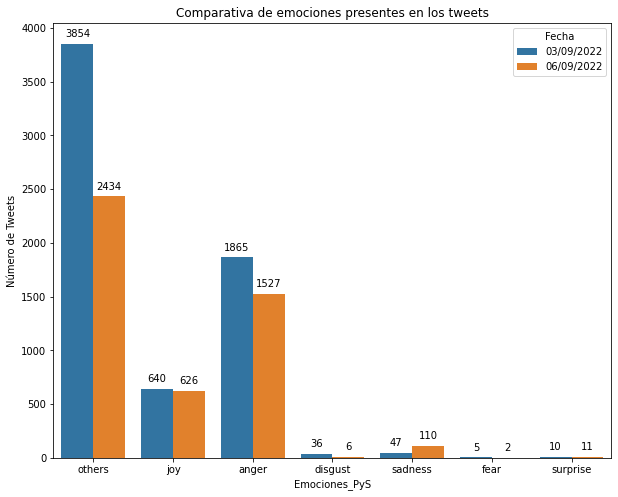

In [47]:
# Gráfico de barras de emociones - Etiquetas por fecha
# ---------------------------------------------------------------------
fig , ax = plt.subplots(figsize = (10,8))

sns.countplot(x    = 'Emociones_PyS', 
              data = df,
              hue  = 'Fecha'
              )
                                      
add_value_labels(ax)  # Ya definida       

plt.ylabel("Número de Tweets")
plt.title('Comparativa de emociones presentes en los tweets')
plt.show()
plt.close('all')

Una de las cosas que no pasa desapercibida en esta comparativa, es el hecho de que la emoción "tristeza" tiene una mayor presencia posterior al plebiscito constitucional que previo a este, pudiendo guardar relación con los resultados del mismo proceso en sí. Algo similar ocurre con las etiquetas relativas a "felicidad" y "sorpresa", que si bien no supera a lo observado previo el proceso en el caso de felicidad, sí alcanza números muy cercanos, lo que sumado a las diferencias iniciales de cantidad de datos de cada período, indica una mayor proporción tweets felices. 

En general, la mayoría de los tweets presentan otras emociones, lo cual puede deberse a temas de neutralidad, así como características propias de las expresiones "chilenas" ya comentadas en el análisis de polaridad, entre otras.




#### Discurso de odio

El análisis de la existencia de un discurso de odio tiene características más complejas, ya que el output puede ser una etiqueta simple, del tipo:

- hateful -> relacionado al odio
- targeted -> relacionado al racismo y la misoginia
- aggressive -> relacionado a la aggressidad

Pero también puede ser "vacío", haciendo alusión a que no hay presencia de discurso de odio, o multi-etiqueta, considerando más de un factor del listado anterior.

Dada la complejidad de este análisis es que se simplificará la codificación para obtener un resultado positivo o negativo a la presencia del discurso de odio.

In [48]:
# Creación del analizador del discurso de odio en español
# ---------------------------------------------------------------------
discurso_de_odio = create_analyzer(task = "hate_speech", 
                                   lang = "es"
                                   )

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-hate-speech/snapshots/272493f45c85fd9b6590716d0206443f2ce79731/config.json
Model config RobertaConfig {
  "_name_or_path": "pysentimiento/robertuito-hate-speech",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "hateful",
    "1": "targeted",
    "2": "aggressive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "aggressive": 2,
    "hateful": 0,
    "targeted": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "probl

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-hate-speech/snapshots/272493f45c85fd9b6590716d0206443f2ce79731/pytorch_model.bin
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at pysentimiento/robertuito-hate-speech.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-hate-speech/snapshots/272493f45c85fd9b6590716d0206443f2ce79731/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-hate-speech/snapshots/272493f45c85fd9b6590716d0206443f2ce79731/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-hate-speech/snapshots/272493f45c85fd9b6590716d0206443f2ce79731/tokenizer_config.json
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [49]:
# Análisis de discurso de odio presente en tweets preprocesados
# ---------------------------------------------------------------------
df['Discurso_de_odio_PyS'] = discurso_de_odio.predict(df['Tweet_T'])

  0%|          | 0/350 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 11173
  Batch size = 32
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [50]:
# Guardado 'Discurso_de_odio_PyS' como string 
# ---------------------------------------------------------------------
df['Discurso_de_odio_PyS'] = df['Discurso_de_odio_PyS'].astype('string')

df.sample(3)

,Fecha,Tweet,Autor,Likes,Retweets,Tweet_T,Polaridad_PyS,Emociones_PyS,Discurso_de_odio_PyS
7136,06/09/2022,#PlebiscitoChile asi fue https://t.co/6rmF2zBSuF,jcff143,0,0,plebiscito chile asi fue url,NEU,others,"AnalyzerOutput(output=[], probas={hateful: 0.1..."
756,03/09/2022,#SumoMiCasaXElApruebo #AprueboCrece #apruebo h...,jossitocastror,1,0,sumo mi casa xel apruebo apruebo crece apruebo...,NEU,joy,"AnalyzerOutput(output=[], probas={hateful: 0.0..."
8047,06/09/2022,Como votante del #Apruebo creo que ya no queda...,cs_kratos,1,0,Como votante del apruebo creo que ya no queda ...,NEU,others,"AnalyzerOutput(output=[], probas={hateful: 0.2..."


In [70]:
# Separación de análisis obtenido y asignación de columnas
# ---------------------------------------------------------------------
aux4         = df['Discurso_de_odio_PyS'].str.split(',', expand = True).astype('string')
aux4.columns = ['cero', 'uno', 'dos', 'tres','cuatro', 'cinco']
aux4.sample(3)

,cero,uno,dos,tres,cuatro,cinco
4568,AnalyzerOutput(output=[],probas={hateful: 0.437,targeted: 0.009,aggressive: 0.148}),<NA>,<NA>
3437,AnalyzerOutput(output=[],probas={hateful: 0.052,targeted: 0.007,aggressive: 0.026}),<NA>,<NA>
4876,AnalyzerOutput(output=[],probas={hateful: 0.219,targeted: 0.011,aggressive: 0.120}),<NA>,<NA>


In [71]:
# Limpieza de texto de etiqueta
# ---------------------------------------------------------------------
aux4['cero'] = aux4['cero'].replace(to_replace = 'AnalyzerOutput\(output=', 
                                    value      = '', 
                                    regex      = True
                                    )

aux4.sample(3)

,cero,uno,dos,tres,cuatro,cinco
4594,[],probas={hateful: 0.263,targeted: 0.018,aggressive: 0.124}),<NA>,<NA>
8389,[],probas={hateful: 0.031,targeted: 0.009,aggressive: 0.018}),<NA>,<NA>
9222,[],probas={hateful: 0.136,targeted: 0.007,aggressive: 0.092}),<NA>,<NA>


In [72]:
# Recodificación de etiquetas
# ---------------------------------------------------------------------
aux4['cero'] = aux4['cero'].apply(lambda x: 'No' if x == '[]' else 'Sí')
aux4.sample(20) # Sampleado grande para ver ambos valores reflejados

,cero,uno,dos,tres,cuatro,cinco
1061,Sí,probas={hateful: 0.548,targeted: 0.009,aggressive: 0.160}),<NA>,<NA>
7411,No,probas={hateful: 0.011,targeted: 0.011,aggressive: 0.014}),<NA>,<NA>
1118,No,probas={hateful: 0.042,targeted: 0.020,aggressive: 0.037}),<NA>,<NA>
899,No,probas={hateful: 0.097,targeted: 0.028,aggressive: 0.062}),<NA>,<NA>
3881,Sí,'targeted','aggressive'],probas={hateful: 0.953,targeted: 0.784,aggressive: 0.877})
2960,No,probas={hateful: 0.016,targeted: 0.008,aggressive: 0.016}),<NA>,<NA>
7708,Sí,probas={hateful: 0.507,targeted: 0.011,aggressive: 0.297}),<NA>,<NA>
2992,No,probas={hateful: 0.046,targeted: 0.014,aggressive: 0.042}),<NA>,<NA>
10554,No,probas={hateful: 0.031,targeted: 0.010,aggressive: 0.026}),<NA>,<NA>
1082,No,probas={hateful: 0.022,targeted: 0.012,aggressive: 0.021}),<NA>,<NA>


In [73]:
# Guardado de etiquetas en df
# ---------------------------------------------------------------------
df['Discurso_de_odio_PyS'] =  aux4['cero']
df.sample(3)

,Fecha,Tweet,Autor,Likes,Retweets,Tweet_T,Polaridad_PyS,Emociones_PyS,Discurso_de_odio_PyS
415,03/09/2022,Así con el copago 0 #Grau #RechazoXAmorAChile ...,Claude67618463,0,0,Así con el copago 0 grau rechazo xamor achile ...,NEU,others,No
1602,03/09/2022,@ExcelenciaTom https://t.co/dQ5qcJ0HAZ RT come...,YoApoyoAChile,0,0,"@usuario url RT comentar y compartir,gobierno ...",NEG,others,No
9422,06/09/2022,"Caras de raja, igual que la izquierda. Estan d...",RafaelTorrebl18,0,0,"Caras de raja, igual que la izquierda. Estan d...",NEG,anger,No


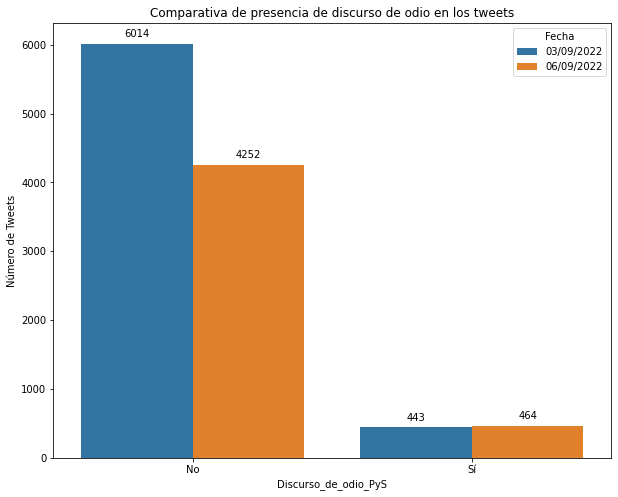

In [74]:
# Gráfico de barras de emociones - Etiquetas por fecha
# ---------------------------------------------------------------------
fig , ax = plt.subplots(figsize = (10,8))

sns.countplot(x    = 'Discurso_de_odio_PyS', 
              data = df,
              hue  = 'Fecha'
              )
                         
add_value_labels(ax)     # Ya definida    

plt.ylabel('Número de Tweets')
plt.title('Comparativa de presencia de discurso de odio en los tweets')
plt.show()
plt.close('all')

En la comparativa visual, se aprecia claramente que los discursos de odio tuvieron una mayor proporción en fecha posterior al plebiscito (específicamente, de un 7%, pasaron a estar presentes en un 11% de los tweets del set de datos). Dado el contexto, se deduce que estos cambios están relacionados a los resultados del plebiscito, y a los otros eventos ocurridos en torno al plebiscito mismo, representados como el descargo de un porcentaje de los usuarios (en opinión personal, una conducta bastante reprochable, que muestra escasa inteligencia emocional desarrollada).Si bien se podrían aludir otras causas, el cruce de información con la nube de palabras del mismo período, reafirma la hipótesis. 

Evidentemente, el aumento del discurso de odio pudo haber aumentado en un porcentaje mucho más significativo, pero aquí se refleja una concoordancia con la alta neutralidad expresada en los tweets del 3 de septiembre. Habría sido poco consecuente que gran parte de la población de usuarios cambiara la forma de abordar el proceso de forma previa... pero no imposible.



### Conclusiones generales

Tanto en etapas previas, como posteriores al plebiscito, Twitter representó un espacio para la discusión de temáticas relacionadas al proceso constituyente, en su mayoría abordadas desde la neutralidad, o desde la negatividad. En este último enfoque se incluían expresiones de enojo y disgusto, así como discursos de odio de los usuarios. 

Definitivamente las campañas "pro abruebo" y "pro rechazo", utilizaron de forma directa e indirecta la plataforma de Twitter como escenario de información e influencia para con los usuarios votantes, representado tanto a nivel de texto como a nivel de hashtags. 

La contingencia que rodeaba el proceso fue bastante discutida y comentada, siendo asociada al "apruebo" o "rechazo" incluso sin ser parte de las campañas mismas o representación de los ideales de cada bando, como fue el caso de la alta cantidad de menciones a la periodista Alejandra del Valle por las opiniones y dichos ante una "performance" en el cierre de la campaña del "apruebo".

Respecto al estudio en sí mismo, se considera que con las herramientas entragdas por **pysentimiento** existen varias posibles profundizaciones para realizar en estudios futuros, por ejemplo, considerando las probabilidades de cada etiqueta y revisando aspectos estadísticos de ellas, para generar correlaciones o patrones entre palabras o temáticas expresadas. También se puede realizar un estudio en extenso sobre los discursos de odio, aislando esos tweets y buscando los targets de dichos discursos, o relaciones entre sí.












## Referencias

* Pérez, J., Giudici, J., & Luque, F. (2021). pysentimiento: A python toolkit for sentiment analysis and socialnlp tasks. arXiv preprint arXiv:2106.09462.

* Pérez, J., Furman, D., Alemany, L., & 
Luque, F. (2021). Robertuito: a pre-trained language model for social media text in spanish. arXiv preprint arXiv:2111.09453.